In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Data aquisition&preparation

In [23]:
# Oxford-IIIT pet dataset: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
dataset_name = "oxford_iiit_pet" # dataset name
split = [
    "train[:60%]+test[:60%]",
    "train[60%:80%]+test[60%:80%]",
    "train[80%:]+test[80%:]"
] # train-validation-test split

In [24]:
# Oxford Flowers 102 dataset: https://www.tensorflow.org/datasets/catalog/oxford_flowers102
dataset_name = "oxford_flowers102" # dataset name
split = [
    "train[:60%]+validation[:60%]+test[:60%]",
    "train[60%:80%]+validation[60%:80%]+test[60%:80%]",
    "train[80%:]+validation[80%:]+test[80%:]"
] # train-validation-test split

In [25]:
# Hyperparameters
img_size = 64 # resized image size
batch_size = 64 # batch size
timesteps = 500 # number of timesteps (noise levels)

In [26]:
def preprocess_image(data): # preprocess an image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width) # find the smallest dimension
    img = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    ) # crop the image to a square
    img = tf.cast(img, dtype=tf.float32) # cast the image to float32
    img = tf.image.resize(img, size=(img_size, img_size), antialias=True) # resize the image to img_size x img_size
    return tf.clip_by_value(img * 2.0 / 255.0, -1.0, 1.0) # normalize the image to [-1, 1]

def reverse_transform(img):
    return tf.clip_by_value((img + 1.0) / 2.0 * 255.0, 0.0, 255.0).numpy().astype(np.uint8) # reverse the normalization

In [27]:
def preprocess_dataset(dataset): # preprocess a dataset
    return (dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # preprocess images of the dataset
            .batch(batch_size, drop_remainder=True) # organize the dataset into batches
            .shuffle(2 * batch_size) # shuffle the dataset
            .prefetch(buffer_size=tf.data.AUTOTUNE)) # prefetch data for better performance

def load_data(dataset_name): # load dataset from tensorflow datasets with the given name
    train_ds, val_ds, test_ds = tfds.load(dataset_name, split=split, shuffle_files=True) # load the dataset
    train_ds = preprocess_dataset(train_ds) # preprocess the training dataset
    val_ds = preprocess_dataset(val_ds) # preprocess the validation dataset
    test_ds = preprocess_dataset(test_ds) # preprocess the test dataset
    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = load_data(dataset_name)

In [63]:
demo_img = next(iter(train_ds.unbatch().take(1)))

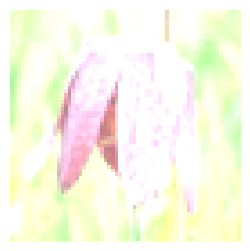

In [164]:
def show(img):
    plt.figure(figsize=(3, 3))
    plt.imshow(reverse_transform(img))
    plt.axis("off")
    plt.show()
    
def plot(imgs):
    _, axs = plt.subplots(figsize=(len(imgs)*2,2), ncols=len(imgs), nrows=1)
    for idx, img in enumerate(imgs):
        axs[idx].imshow(reverse_transform(img))
        axs[idx].axis("off")
    plt.tight_layout()

show(demo_img)

## Forward Diffusion Process 

In [168]:
class Diffusion:
    def __init__(self, timesteps=1000, min_beta=0.0001, max_beta = 0.02):
        self.timesteps = timesteps # number of timesteps (noise levels)
        self.min_beta = min_beta # first beta
        self.max_beta = max_beta # last beta
        
        self.betas = tf.linspace(min_beta, max_beta, timesteps) # setting schedule for beta (linear schedule)
        self.alphas = 1 - self.betas # alpha_t = 1 - beta_t
        self.alphas_cum_prod = tf.math.cumprod(self.alphas) # cumulative product of alphas
        self.alphas_cum_prod_prev = tf.concat([[1.0], self.alphas_cum_prod[:-1]], axis=0) # cumulative product of alphas shifted
        self.recip_sqrt_alphas = tf.math.square(1.0 / self.alphas) # reciprocals of squares of alphas
        self.sqrt_alphas_prod = tf.math.square(self.alphas_cum_prod) # squares of cumulative product of alphas
        self.sqrt_one_minus_alphas_prod = tf.math.square(1.0 - self.alphas_cum_prod) # squares of 1 - cumulative product of alphas
        
        # posterior variance (Equation 6, 7)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cum_prod_prev) / (1.0 - self.alphas_cum_prod)
        
    def extract(self, series, t, x_shape):
        out = tf.gather(series, t)
        return tf.reshape(out, [x_shape[0], 1, 1, 1])
    
    def q_sample(self, x_start, t, noise=None):
        x_start_shape = tf.shape(x_start)
        if noise is None:
            noise = tf.random.normal(x_start_shape, dtype=x_start.dtype)
        
        sqrt_alphas_prod_t = self.extract(self.sqrt_alphas_prod, t, x_start_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_start_shape)
        return sqrt_alphas_prod_t * x_start + sqrt_one_minus_alphas_prod_t * noise # Equation 12
    
    def p_sample(self, model, x, t, t_index):
        x_shape = tf.shape(x)
        beta_t = self.extract(self.betas, t, x_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_shape)
        recip_sqrt_alphas_t = self.extract(self.recip_sqrt_alphas, t, x_shape)
        model_mean = recip_sqrt_alphas_t * (x - model(x, t) * beta_t / sqrt_one_minus_alphas_prod_t) # Equation 11
        
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x_shape)
            noise = tf.random.normal(x_shape, dtype=x.dtype) # sample noise from N(0, I)
            return model_mean + tf.math.square(posterior_variance_t) * noise # Algorith 2, Line 4

In [169]:
forward_diffusion = Diffusion(timesteps)

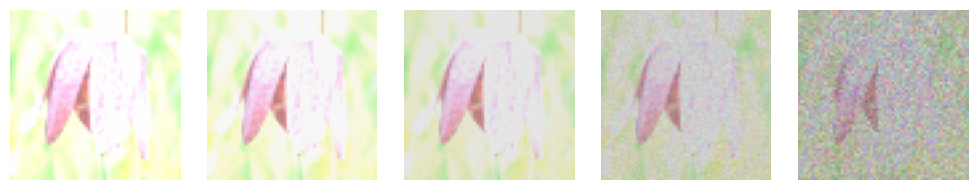

In [170]:
noisy_images = [tf.squeeze(forward_diffusion.q_sample(tf.expand_dims(demo_img, 0), tf.constant([t]))) for t in [0, 50, 100, 150, 200]]
plot(noisy_images)

## Neural network

A basic autoencoder for milestone 2

In [ ]:
class BasicModel(tf.keras.Model):
    def __init__(self, latent_dim=64):
        super(BasicModel, self).__init__()
        self.latent_dim = latent_dim
        self.loss = tf.keras.losses.MeanSquaredError() # MSE loss
        
        self.encoder = tf.keras.Sequential([
            # TODO
        ])
        
        self.decoder = tf.keras.Sequential([
            # TODO
        ])
        
    def train_step(self, Xs):
        # TODO: samle timesteps uniformly from [0, timesteps], sample Gaussian noise, diffuse images (q_sample), give it to the  network, calculate loss, backpropagate
        pred = self.decoder(self.encoder(Xs))
        return # TODO: return loss